In [2]:
import os
from collections import Counter
from itertools import product
from tqdm import tqdm
import torch
import torch.nn as nn
import math
import random
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torcheval.metrics.text import Perplexity
import nltk
from sentence_transformers import SentenceTransformer

c:\Users\mrmrk\OneDrive\Documents\GitHub\AI-modeling\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [4]:


folder_path = 'dat410_europarl/'

translations = {}
file_list = os.listdir(folder_path)
text_files = [file for file in file_list]
for text_file in text_files:
    file_path = os.path.join(folder_path, text_file)
    with open(file_path, 'r', encoding='utf-8') as file:
        translations[file_path.split(".")[-1]] = [l[:-1] for l in file.readlines()]
        
translations["sv"]

['jag förklarar europaparlamentets session återupptagen efter avbrottet den 17 december . jag vill på nytt önska er ett gott nytt år och jag hoppas att ni haft en trevlig semester .',
 'som ni kunnat konstatera ägde &quot; den stora år 2000-buggen &quot; aldrig rum . däremot har invånarna i ett antal av våra medlemsländer drabbats av naturkatastrofer som verkligen varit förskräckliga .',
 'ni har begärt en debatt i ämnet under sammanträdesperiodens kommande dagar .',
 'till dess vill jag att vi , som ett antal kolleger begärt , håller en tyst minut för offren för bl.a. stormarna i de länder i europeiska unionen som drabbats .',
 'jag ber er resa er för en tyst minut .',
 'ni känner till från media att det skett en rad bombexplosioner och mord i sri lanka .',
 'en av de personer som mycket nyligen mördades i sri lanka var kumar ponnambalam , som besökte europaparlamentet för bara några månader sedan .',
 'skulle det vara möjligt för er , fru talman , att skriva ett brev till den srilank

In [5]:
simpel_translator = torch.load("simpel_translator.pth")

In [6]:
translator_dict = {}
for (swe_word, eng_word), prob in simpel_translator.items():
    eng_dict = translator_dict.get(eng_word, {})
    eng_dict[swe_word] = prob
    translator_dict[eng_word] = eng_dict


In [7]:

def simpel_translate_setance(sentence, translator_dict):
    out = []
    for word in sentence.split(" "):
        out.append(max(translator_dict[word], key=lambda k: translator_dict[word][k]))
    return " ".join(out)
sentence = "mrs lynne , you are quite right and i shall check whether this has actually not been done ."

simpel_translate_setance(sentence, translator_dict)

'. lynne , ni är helt rätt och jag kommer kontrollera om detta har verkligen inte har gjort .'

In [8]:
swe_count = Counter(" ".join(translations["sv"]).split(" "))
eng_count = Counter(" ".join(translations["en"]).split(" "))
print(swe_count.most_common(20))
print(eng_count.most_common(20))

[('.', 9648), ('att', 9181), (',', 8876), ('och', 7038), ('i', 5949), ('det', 5687), ('som', 5028), ('för', 4959), ('av', 4013), ('är', 3840), ('en', 3724), ('vi', 3211), ('jag', 3093), ('den', 2953), ('de', 2930), ('om', 2909), ('till', 2837), ('på', 2783), ('har', 2484), ('inte', 2385)]
[('the', 19322), (',', 13514), ('.', 9774), ('of', 9312), ('to', 8801), ('and', 6946), ('in', 6090), ('is', 4400), ('that', 4357), ('a', 4269), ('we', 3223), ('this', 3222), ('i', 2964), ('for', 2942), ('be', 2550), ('it', 2426), ('on', 2304), ('which', 2026), ('are', 1917), ('have', 1881)]


In [9]:


model_name = 'bert-base-nli-mean-tokens'
bert_model = SentenceTransformer(model_name)
def split_into_chunks(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]


In [10]:
bert_encodings = torch.tensor(bert_model.encode(translations["en"]))
bert_encodings.shape

torch.Size([10000, 768])

In [11]:
swe_vocab = [t[0] for t in swe_count.most_common()]
swe_vocab = ["<UKN>", "<PAD>", "<s>", "</s>"] + swe_vocab[:int(len(swe_vocab) * 0.35)]
print("Portion of unknow swedish words in the corpus", 1 -sum([swe_count[w] for w in swe_vocab]) / sum(swe_count.values()))
print("Length of vocab",  len(swe_vocab))

Portion of unknow swedish words in the corpus 0.05783098983711543
Length of vocab 6441


In [12]:
swe_id2word = {i:w for i, w in enumerate(swe_vocab)}
swe_word2id = {w:i for i, w in enumerate(swe_vocab)}

In [13]:
swe_id2word[3572]

'åsikten'

In [14]:
#Transalte wprds in to ids, with start and end tokens at respective ends
swe_tokens = [[2] + [swe_word2id.get(w, 0) for w in scent.split(" ")] + [3] for scent in  translations["sv"]]
max_len = max([len(ids) for ids in swe_tokens])
#Add padding such that all scentances are of equal length
swe_tokens = [scent + [1] * (max_len - len(scent)) for scent in swe_tokens]
#Assert that they are of equal length
assert all([len(ids) == len(swe_tokens[0]) for ids in swe_tokens])
swe_tokens, len(swe_tokens), len(swe_tokens[0])

([[2,
   16,
   1553,
   424,
   3535,
   4943,
   127,
   4141,
   17,
   2101,
   969,
   4,
   16,
   37,
   21,
   311,
   2102,
   94,
   25,
   913,
   311,
   99,
   7,
   16,
   183,
   5,
   53,
   508,
   14,
   6285,
   6286,
   4,
   3,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
 

In [15]:
def random_split_list(input_list, split_ratio):
    assert 0 <= split_ratio <= 1, "Split ratio must be between 0 and 1"

    values = input_list.copy()
    random.shuffle(values)

    split_index = int(len(values) * split_ratio)
    first_list = values[:split_index]
    second_list = values[split_index:]

    return first_list, second_list

In [16]:
train_indecies, rest = random_split_list(list(range((bert_encodings.shape[0]))), 0.7)
val_indecies, test_indecies= random_split_list(rest, 0.5)
assert len(train_indecies) + len(val_indecies) + len(test_indecies) == bert_encodings.shape[0]
assert sorted(train_indecies + val_indecies + test_indecies) == list(range(bert_encodings.shape[0]))
train_indecies[:10], val_indecies[:10], test_indecies[:10]

([127, 8441, 3474, 5438, 1322, 7596, 6866, 678, 2248, 5380],
 [4897, 2349, 1225, 4059, 3300, 8393, 4491, 5662, 6776, 206],
 [8049, 6021, 2924, 4070, 4798, 7865, 4150, 5260, 6771, 2113])

In [17]:
train_eng = bert_encodings[train_indecies]
train_swe = torch.tensor(swe_tokens)[train_indecies]

val_eng = bert_encodings[val_indecies]
val_swe = torch.tensor(swe_tokens)[val_indecies]

test_eng = bert_encodings[test_indecies]
test_swe = torch.tensor(swe_tokens)[test_indecies]

assert train_eng.shape[0] + val_eng.shape[0] + test_eng.shape[0] == bert_encodings.shape[0]
train_eng.shape

torch.Size([7000, 768])

In [18]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size, dropout_prob):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hidden_dim * num_layers, output_size)

    def forward(self, input_text):
        embedded_text = self.embedding(input_text)
        lstm_out, (hiddens, _) = self.lstm(embedded_text)
        concat_hiddens = hiddens.permute(1, 0, 2).flatten(start_dim=1)
        output = self.linear(concat_hiddens)  # Apply linear layer
        return output
    
class TextDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size,num_layers, encoding_size, dropout):
        super(TextDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoding_size = encoding_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim + encoding_size, hidden_size, num_layers,  dropout=dropout, batch_first=True)# Concatenated input size: hidden_size + encoding_size
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)  # Change softmax dimension to 2

    def forward(self, encoding, input, hidden = None):
        #if hidden == None:
            #hidden = torch.zeros((input.shape[0], self.hidden_size))
        seq_len = input.size(1)
        
        # Repeat encoding along the sequence dimension
        repeated_encoding = encoding.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Embed the input tokens
        embedded_input = self.embedding(input)
        
        # Concatenate embedding with encoding
        concatenated_input = torch.cat((embedded_input, repeated_encoding), dim=2)
        
        # Pass through RNN
        if hidden != None:
            output, hidden = self.rnn(concatenated_input, hidden)
        else:
            output, (hidden) = self.rnn(concatenated_input)
        
        # Compute output probabilities
        output = self.out(output)
        
        return output, hidden

In [19]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input, target, teacher_forcing = True, start_token = None, max_length = None):
        context = self.encoder(input)
        return self.decoder(context, target, teacher_forcing, start_token, max_length)
    
class Encoder(nn.Module):
    def __init__(self, in_vocab_size,out_vocab_size, embedding_dim_in,embedding_dim_out,
                            hidden_dim, num_layers, dropout_rate):
        super(Encoder, self).__init__()
        self.out_vocab_size = out_vocab_size
        self.num_layers = num_layers
        self.in_embedding = nn.Embedding(in_vocab_size, embedding_dim_in)
        self.lstm = nn.LSTM(embedding_dim_in, hidden_dim, num_layers=num_layers, 
                                       dropout=dropout_rate, batch_first=True)

    def forward(self, context_sequence):
        # LSTM encoding for context_sequence
        embeded = self.in_embedding(context_sequence)
        _ , (hidden, cells) = self.lstm(embeded)
        return (hidden, cells)
class Decoder(nn.Module):
    def __init__(self,out_vocab_size,embedding_dim_out,
                 hidden_dim, num_layers, dropout_rate):
            super(Decoder, self).__init__()
            self.dropout = nn.Dropout(dropout_rate)
            self.out_embedding = nn.Embedding(out_vocab_size, embedding_dim_out)
            self.lstm = nn.LSTM(embedding_dim_out, hidden_dim, num_layers=num_layers,
                            dropout=dropout_rate, batch_first=True)
            self.fc = nn.Linear(hidden_dim, out_vocab_size)

    def forward(self, hidden, x, teacher_forcing = True, start_token = None, max_length = None):
        


        # Embedding for input sequence
        embedding_x = self.dropout(self.out_embedding(x))

        #layered_context = context.repeat(self.num_layers_de, 1, 1)
        
       
        
        
        if teacher_forcing:
            # LSTM processing
            output, hidden = self.lstm(embedding_x, hidden)
        else:
            assert start_token != None and max_length != None
            
            decoder_input = self.out_embedding(torch.tensor([[start_token]] * x.shape[0], device=device))
            decoder_outputs = None
            
          
            for t in range(max_length):
                decoder_output, hidden = self.lstm(decoder_input, hidden)
                if decoder_outputs == None:
                    decoder_outputs = decoder_output
                else:
                    decoder_outputs = torch.cat((decoder_outputs, decoder_output), dim = 1)
                
                # Use the predicted token as input for the next timestep
                probs =  self.fc(decoder_output.float())
                decoder_input = self.out_embedding(probs.argmax(dim=2))
            output = decoder_outputs
            
            

        # Apply dropout
        output = self.dropout(output)

        # Final prediction
        prediction = self.fc(output)
        return prediction



In [20]:
class Vec2hidden(nn.Module):
    def __init__(self, num_layers) -> None:
        super().__init__()
        self.num_layers = num_layers
    def forward(self, context):
        layered_context = context.repeat(self.num_layers, 1, 1)
        hidden = (layered_context.to(device), torch.zeros_like(layered_context).to(device))
        return hidden

In [21]:
def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data)):
        start_index = max(0, i - window_size + 1)
        end_index = min(i + 1, len(data))
        window = data[start_index:end_index]
        average = sum(window) / len(window)
        moving_averages.append(average)
    return moving_averages

In [22]:
def dec_order_any(values, n):
    if len(values) <= 1:
        return True
    lessers = [a> b for a,b in zip(values[:-1], values[1:])]
    if  n >= len(lessers):
        return any(lessers)
    return any(lessers[-n:])
dec_order_any([10], 2)

True

In [23]:

swe_vocab_size= len(swe_vocab)
hidden_size = 768
de_embed_size = 1024
depth = 5
drop_rate = 0.1


prob_threahold = 0
prob_step = 0
lr  = 0.0005
batch_size = 8

num_epochs = 10
wd = 2e-6

early_stop = 4

c = 1

In [24]:
force = False
model_name = "bertEnc.pth"

decoder_args = (swe_vocab_size, de_embed_size, hidden_size, depth, drop_rate)
if not os.path.exists(model_name) or force:
    
    model = Seq2seq(Vec2hidden(depth), Decoder(swe_vocab_size, de_embed_size, hidden_size, depth, drop_rate).to(device))
    
    train_loader = DataLoader(TensorDataset(train_eng, train_swe), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_eng, val_swe), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_function = nn.CrossEntropyLoss()
    #progress = tqdm(total=num_epochs * (len(train_loader) / batch_size + len(val_loader) / batch_size + 2))

    train_losses = []
    val_losses = []
    epochs_mean_val_losses = []
    try:
        for epoch in (range(num_epochs)):
            total_loss = 0
            num_batches = 0
            epoch_train_losses = []
            epoch_val_losses = []
            nr_batches = len(train_loader)
            for eng_encoding, swe_text in tqdm(train_loader):
                prob_threahold += prob_step / nr_batches

                eng_encoding = eng_encoding.to(device)
                indecies = torch.where((swe_text == 1).sum(dim =0) == batch_size)[0]
                first_pad_swe = indecies[0].item() if indecies.shape[0] != 0 else swe_text.shape[1]
                swe_text = swe_text[:, :first_pad_swe].to(device)
                

            
               
                if prob_threahold < random.random():
                    decoding = model.forward(eng_encoding, swe_text[:,:-1]) #teacherforcing
                else:
                    decoding = model.forward(eng_encoding, swe_text[:,:-1], 
                                            False, swe_word2id["</s>"], int(swe_text[:,1:].shape[1])) #autoregresive
                
                ground_truth = F.one_hot(swe_text[:,1:], swe_vocab_size).float()
                flat_preds = decoding.view(-1, decoding.size(-1))
                flat_target = ground_truth.view(-1, ground_truth.size(-1))
                loss = loss_function(flat_preds, flat_target) * batch_size / flat_preds.shape[0]
               
                
                optimizer.zero_grad()
            
                loss.backward()
                
                optimizer.step()
                epoch_train_losses.append(loss.item())


            for eng_encoding, swe_text in (val_loader):
                with torch.no_grad():
                    
                    eng_encoding = eng_encoding.to(device)
                    indecies = torch.where((swe_text == 1).sum(dim =0) == batch_size)[0]
                    first_pad_swe = indecies[0].item() if indecies.shape[0] != 0 else swe_text.shape[1]
                    swe_text = swe_text[:, :first_pad_swe].to(device)
                    
                    decoding = model.forward(eng_encoding, swe_text[:,:-1]) #teacherforcing
                  
                    ground_truth = F.one_hot(swe_text[:,1:], swe_vocab_size).float()
                    flat_preds = decoding.view(-1, decoding.size(-1))
                    flat_target = ground_truth.view(-1, ground_truth.size(-1))
                    loss = loss_function(flat_preds, flat_target) * batch_size / flat_preds.shape[0]
                    
                    epoch_val_losses.append(loss.item())

            val_losses.extend(epoch_val_losses)
            train_losses.extend(epoch_train_losses)

            print("train ",sum(epoch_train_losses) / len(epoch_train_losses), "val", sum(epoch_val_losses) / len(epoch_val_losses))

            epochs_mean_val_losses.append(sum(epoch_val_losses) / len(epoch_val_losses))
            """if not dec_order_any(epochs_mean_val_losses, early_stop):
                print("val went up", early_stop, "times")
                break"""
    except KeyboardInterrupt:
        torch.save({"model": model.state_dict(), 
                    "decoder_args": decoder_args,
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "lr":lr, 
                    "batch_size": batch_size, 
                    "num_epochs":num_epochs, 
                    "wd":wd },
                    model_name)
    torch.save({"model": model.state_dict(), 
                        "decoder_args": decoder_args,
                        "train_losses": train_losses,
                        "val_losses": val_losses,
                        "lr":lr, 
                        "batch_size": batch_size, 
                        "num_epochs":num_epochs, 
                        "wd":wd },
                        model_name)

In [25]:
model_dict = torch.load(model_name)
train_losses =model_dict["train_losses"]
val_losses = model_dict["val_losses"]
model = Seq2seq(Vec2hidden(depth),Decoder(*model_dict["decoder_args"])).to(device)
model.load_state_dict(model_dict["model"])

<All keys matched successfully>

In [26]:
model_dict["wd"]

2e-06

In [27]:
test_eng.shape, test_swe.shape

(torch.Size([1500, 768]), torch.Size([1500, 161]))

In [28]:
"""def calculate_perplexity(model, dataloader, device):

    with torch.no_grad():
        metric=Perplexity().to(device)
        perplexities = []
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            encodings = model.forward_context(inputs)
            preds = model.forward(encodings, targets)
            
            if preds.shape[0] == targets.shape[0]:
                metric.update(preds, targets)
                perplexity = metric.compute()
                perplexities.append(perplexity.item())
            else:
                print(":(")

    return sum(perplexities) / len(perplexities)

d = torch.load("perplexities.pth")
if d.get(model_name[:-4], None) == None or force:
    p = calculate_perplexity(model, DataLoader(TensorDataset(test_eng, test_swe), batch_size=8), device)
    d[model_name[:-4]] = p
    torch.save(d, "perplexities.pth")

d[model_name[:-4]], d"""

'def calculate_perplexity(model, dataloader, device):\n\n    with torch.no_grad():\n        metric=Perplexity().to(device)\n        perplexities = []\n        for inputs, targets in tqdm(dataloader):\n            inputs, targets = inputs.to(device), targets.to(device)\n            encodings = model.forward_context(inputs)\n            preds = model.forward(encodings, targets)\n            \n            if preds.shape[0] == targets.shape[0]:\n                metric.update(preds, targets)\n                perplexity = metric.compute()\n                perplexities.append(perplexity.item())\n            else:\n                print(":(")\n\n    return sum(perplexities) / len(perplexities)\n\nd = torch.load("perplexities.pth")\nif d.get(model_name[:-4], None) == None or force:\n    p = calculate_perplexity(model, DataLoader(TensorDataset(test_eng, test_swe), batch_size=8), device)\n    d[model_name[:-4]] = p\n    torch.save(d, "perplexities.pth")\n\nd[model_name[:-4]], d'

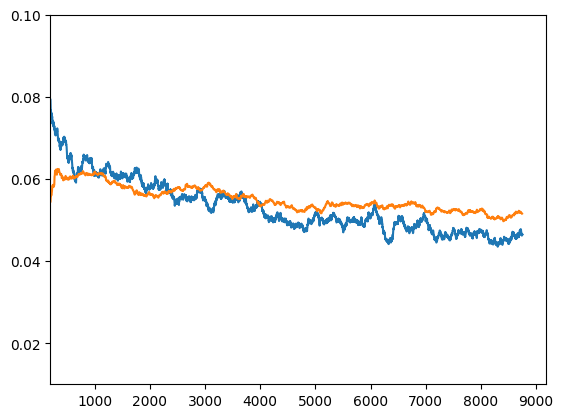

In [32]:


plt.plot((range(len(train_losses))), moving_average(train_losses, 200))
x = [int(a * len(train_losses) / len(val_losses)) for a in range(len(val_losses))]
plt.plot(x, moving_average(val_losses, 200))
plt.ylim(0.01, 0.1)
plt.xlim(200)
plt.show()

In [30]:

def select_from_topk(input_tensor, k):
    values, indecies = torch.topk(input_tensor, k, dim=1)
    sub_indecy = torch.multinomial(values[0], 1, replacement=True)[0].item()
    return indecies[0,sub_indecy]

def translate(model ,input_encoding, out_vocab,out_start_token, out_end_token, k = 5, max = 20):
    model.eval()
    with torch.no_grad():
        translation = torch.tensor([out_start_token]).to(device)
        hidden = None
        for _ in range(max):
            output = model.forward(input_encoding, translation.unsqueeze(0))
            logits = output[0,-1]
            logits[0] = float('-inf')
            logits[2] = float('-inf')
            next_token_prob = torch.softmax(logits, dim = 0)
            a = select_from_topk(next_token_prob.unsqueeze(0), k).to(device)
            translation = torch.concat((translation, a.unsqueeze(0)))
            if a == out_end_token:
                break
        return " ".join([out_vocab[int(t.item())] for t in translation])


In [31]:
encoding = torch.tensor(bert_model.encode("you have not.")).unsqueeze(0)
translate(model,encoding , swe_id2word, 
          swe_word2id["<s>"], swe_word2id["</s>"],
          k = 10, max=30)

'<s> men vi känner till en sådan . </s>'